In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [2]:
# Load and preprocess the dataset
data = pd.read_csv('sample_data/Sample_Dataset.csv')  # Update the file path if necessary

In [3]:
# Select input features and target columns
input_features = [
    'X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
    'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
    'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage',
    'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration',
    'Y1_CommandPosition', 'Y1_CommandVelocity', 'Y1_CommandAcceleration',
    'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
    'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration',
    'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration',
    'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage',
    'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration',
    'S1_CommandPosition', 'S1_CommandVelocity', 'S1_CommandAcceleration',
    'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage'
]
target_columns = ['X1_OutputPower', 'Y1_OutputPower', 'S1_OutputPower']

In [4]:
# Split the data into input (X) and output (y)
X = data[input_features]
y = data[target_columns]

In [5]:
# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Convert the data into sequences for LSTM
sequence_length = 10  # Adjust the sequence length as needed
X_sequence = []
y_sequence = []

In [8]:
# Ensure y is also aligned with X in sequences
for i in range(len(X_scaled) - sequence_length):
    X_sequence.append(X_scaled[i:i+sequence_length])
    y_sequence.append(y.iloc[i+sequence_length].values)  # Ensure y is accessed correctly

X_sequence = np.array(X_sequence)
y_sequence = np.array(y_sequence)

print("X_sequence shape:", X_sequence.shape)
print("y_sequence shape:", y_sequence.shape)

X_sequence shape: (3590, 10, 40)
y_sequence shape: (3590, 3)


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

In [12]:
# Define a pre-trained model (For demonstration purpose, we'll create and save it first)
pretrained_model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1])
])
pretrained_model.compile(optimizer='adam', loss='mean_squared_error')
pretrained_model.save('pretrained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Load the pre-trained model
model = load_model('pretrained_model.h5')

# Freeze the first few layers (for transfer learning)
for layer in model.layers[:-2]:
    layer.trainable = False

# Optionally add new layers if necessary
model.add(Dense(32, activation='relu'))  # Example of adding a new layer
model.add(Dense(y_train.shape[1]))

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('pretrained_milling_machine_model_frozen.keras', save_best_only=True)
]

# Train the neural network
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)


Epoch 1/10
72/72 [==============================] - 4s 16ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2/10
72/72 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/10
72/72 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/10
72/72 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/10
72/72 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/10
72/72 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/10
72/72 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/10
72/72 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0011


In [25]:
# Evaluate the model on test data
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)

Training Mean Squared Error: 0.0010240240953862667
Testing Mean Squared Error: 0.0009963737102225423


In [17]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

23/23 [==============================] - 0s 6ms/step


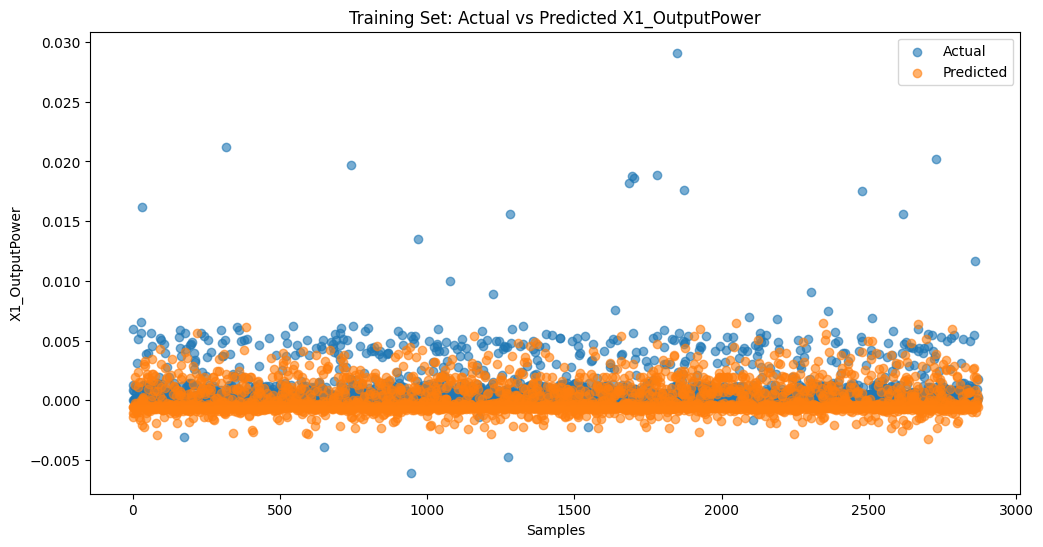

In [26]:
# Plot Actual vs Predicted for X1_OutputPower on Training Set
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_train)), y_train[:, 0], label='Actual', alpha=0.6)
plt.scatter(range(len(y_train)), train_predictions[:, 0], label='Predicted', alpha=0.6)
plt.title('Training Set: Actual vs Predicted X1_OutputPower')
plt.xlabel('Samples')
plt.ylabel('X1_OutputPower')
plt.legend()
plt.show()


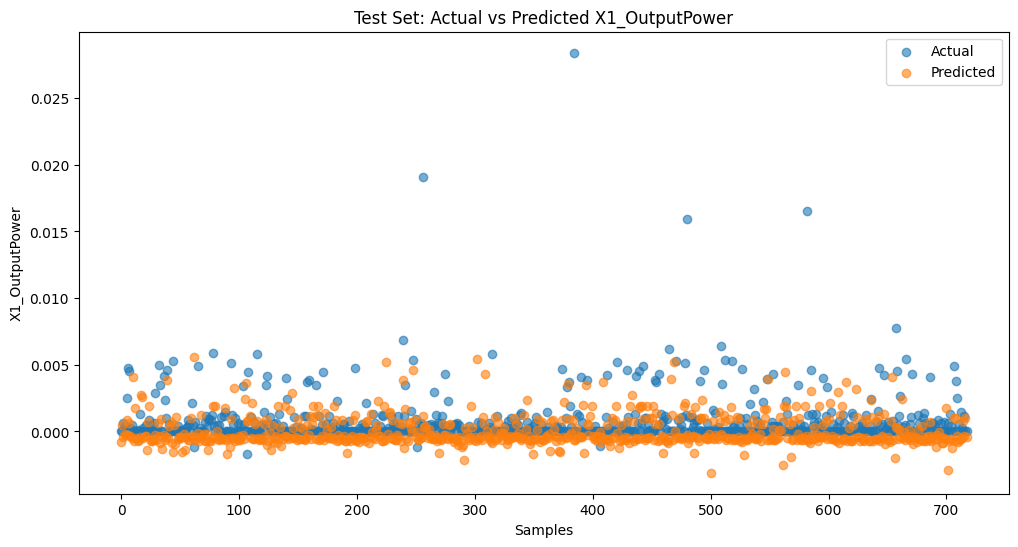

In [27]:
# Plot Actual vs Predicted for X1_OutputPower on Test Set
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test[:, 0], label='Actual', alpha=0.6)
plt.scatter(range(len(y_test)), test_predictions[:, 0], label='Predicted', alpha=0.6)
plt.title('Test Set: Actual vs Predicted X1_OutputPower')
plt.xlabel('Samples')
plt.ylabel('X1_OutputPower')
plt.legend()
plt.show()
